# Grand Tour 

In [12]:
# Defining the function to map decimal input to the corresponding sides being blackened
def blackened_sides(decimal_number):

    sides = ["T","L","B", "R"]
    # Convert the decimal number to 4-bit binary, padded with zeros if necessary
    binary_representation = format(decimal_number, '04b')
    print(binary_representation)
    blackened = [sides[i] for i in range(4) if binary_representation[i] == '1']
    return blackened

# Test the function with the input 7
blackened_sides(7)


0111


['L', 'B', 'R']

In [8]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as grb
import numpy as np
import os
from matplotlib.pyplot import MultipleLocator
from matplotlib.patches import Rectangle

In [14]:
def readInstance(path):
    
    # 从测试案例中随机选取一个测试案例出来
    # file_name = f"../assets/data/GrandTourSolverdata/{path}{np.random.randint(1)+1}.txt"
    file_name = f"../assets/data/GrandTour/{path}.txt"

    m = 0
    n = 0
    grids = None
    print( f"READING FILE {file_name}" )
    if not os.path.isfile(file_name):
        print('File does not exist')
    else:
        # keys = ['m', 'n', 'w', 'p']
        # d = dict()
        
        with open(file_name) as file:
            firstline = file.readline().strip().split(" ")
            m = int(firstline[0])
            n = int(firstline[1])
            grids = [[0 for _ in range(n)] for _ in range(m)]

            for idx in range(m):
                line = file.readline().strip().split(" ")
                assert len(line) == n
                for j in range(n):
                    if line[j] not in ['-']:
                        grids[idx][j] = int(line[j])
    return m, n, grids

if __name__ == "__main__":
    data = "15x15"
    m, n, grids = readInstance(data)
    print(m,n)
    print(grids)

READING FILE ../assets/data/GrandTour/15x15.txt
15 15
[[0, 8, 0, 0, 2, 0, 0, 2, 0, 1, 4, 0, 0, 8, 0], [4, 0, 0, 0, 8, 0, 2, 8, 0, 1, 6, 2, 0, 0, 0], [0, 2, 0, 1, 4, 0, 9, 4, 0, 0, 8, 8, 0, 1, 6], [0, 9, 6, 1, 4, 0, 0, 1, 4, 1, 4, 0, 0, 0, 8], [0, 0, 8, 0, 2, 0, 0, 1, 4, 0, 2, 2, 1, 4, 2], [0, 1, 4, 1, 12, 2, 0, 1, 4, 0, 8, 8, 0, 0, 8], [0, 1, 4, 2, 2, 8, 0, 1, 4, 1, 6, 0, 2, 0, 0], [0, 1, 4, 8, 8, 2, 1, 4, 2, 0, 8, 0, 8, 0, 0], [2, 3, 4, 0, 0, 9, 5, 4, 8, 0, 0, 0, 0, 1, 4], [8, 8, 0, 0, 2, 0, 0, 0, 0, 1, 4, 1, 4, 0, 0], [0, 0, 0, 2, 8, 0, 2, 0, 1, 4, 0, 2, 0, 2, 0], [2, 0, 0, 8, 0, 1, 13, 4, 0, 1, 4, 8, 0, 10, 0], [8, 0, 1, 4, 0, 0, 1, 4, 0, 1, 6, 2, 0, 8, 0], [1, 4, 1, 4, 1, 4, 2, 1, 4, 0, 8, 9, 4, 0, 2], [1, 4, 0, 1, 4, 0, 8, 0, 1, 6, 0, 0, 0, 0, 8]]


In [15]:
def GrandTourWithLazyCuts(m, n, grids):
    GrandTourSolver = grb.Model("GrandTour")
    x = dict()
    to_dict = dict()
    node_nums = (m + 1) * (n + 1)
    for i in range(m + 1):
        for j in range(n + 1):
            if j + 1 <= n:
                x[i * (n + 1) + j, i * (n + 1) + j + 1] = GrandTourSolver.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1) + j},{i * (n + 1) + j + 1}]"
                )
            if i < m:
                x[i * (n + 1) + j, (i + 1) * (n + 1) + j] = GrandTourSolver.addVar(
                    vtype=grb.GRB.BINARY,
                    obj = 1,
                    name = f"x[{i * (n + 1)},{(i + 1) * (n + 1)}]"
                )
    print(f"ALL LINES (WITHOUT DUP) {len(x)}")
    GrandTourSolver.modelSense = grb.GRB.MINIMIZE
    GrandTourSolver.Params.lazyConstraints = 1
    GrandTourSolver.update()
    
    for (ori, dep) in x.keys():
        if ori not in to_dict:
            to_dict[ori] = [[ori, dep]]
        else:
            to_dict[ori].append([ori, dep])
        if dep not in to_dict:
            to_dict[dep] = [[ori, dep]]
        else:
            to_dict[dep].append([ori, dep])
    
    for i in range(node_nums):
        GrandTourSolver.addConstr(grb.quicksum(x[i, j] for (i, j) in to_dict[i]) == 2, name = f"BALANCE_{i}")
    for i in range(m):
        for j in range(n):
            if grids[i][j] == 0:
                continue
            edges = blackened_sides(grids[i][j])
            for edge in edges:
                if edge == 'L':
                    GrandTourSolver.addConstr(x[i * (n + 1) + j, (i + 1) * (n + 1) + j] == 1, name = f"L_{i}_{j}")
                if edge == "R":
                    GrandTourSolver.addConstr(x[i * (n + 1) + j + 1, (i + 1) * (n + 1) + j + 1 ] == 1, name = f"R_{i}_{j}")
                if edge == "B":
                    GrandTourSolver.addConstr(x[(i + 1) * (n + 1) + j, (i + 1) * (n + 1) + j + 1 ] == 1, name = f"B_{i}_{j}")
                if edge == "T":
                    GrandTourSolver.addConstr(x[i * (n + 1) + j, i * (n + 1) + j + 1 ] == 1, name = f"T_{i}_{j}")
                    
    def subtourelim(model, where):
        # 回调函数
        if (where == grb.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            # 从新的 MIP 解决方案中检索值。
            G = nx.Graph()
            nodes_appear = []
            for (i, j) in x.keys():
                if (x_sol[i, j] > 0.9):
                    if i not in nodes_appear:
                        nodes_appear.append(i)
                    if j not in nodes_appear:
                        nodes_appear.append(j)
                    G.add_edge(i, j, weight = 1)
            components = [list(c) for c in nx.connected_components(G)]
            # 获得当前图里所有的子环路
            print("The length is " + str(len(components)))
            for component in components:
                if (len(component) < len(nodes_appear)):
                    # 消除那些环路
                    print("Add cut")
                    model.cbLazy(grb.quicksum(x[i,j] for i in component \
                        for j in component if j in to_dict[i]) <= len(component) - 1)
                    
    GrandTourSolver._x = x
    GrandTourSolver.optimize(subtourelim)
    ofv = None
    seq = []
    arcs = []
    solType = None
    gap = None
    lb = None
    ub = None
    runtime = None
    if (GrandTourSolver.status == grb.GRB.status.OPTIMAL):
        solType = 'IP_Optimal'
        ofv = GrandTourSolver.getObjective().getValue()
        print(ofv)
        for i, j in x:
            if (x[i, j].x > 0.5):
                arcs.append([i, j])
        # assert len(arcs) == len(nodes_pos) - 1
        # currentNode = nodeIDs[0]
        # seq.append(currentNode)
        # while (len(arcs) > 0):
        #     for i in range(len(arcs)):
        #         if (arcs[i][0] == currentNode):
        #             currentNode = arcs[i][1]
        #             seq.append(currentNode)
        #             arcs.pop(i)
        #             break
        gap = 0
        lb = ofv
        ub = ofv
        runtime = GrandTourSolver.Runtime
    elif (GrandTourSolver.status == grb.GRB.status.TIME_LIMIT):
        solType = 'IP_TimeLimit'
        ofv = None
        seq = []
        gap = GrandTourSolver.MIPGap
        lb = GrandTourSolver.ObjBoundC
        ub = GrandTourSolver.ObjVal
        runtime = GrandTourSolver.Runtime


    
    return {
        "TotalCost": ofv,
        "runtime": runtime,
        "arcs": arcs
    }

if __name__ == "__main__":
    result = GrandTourWithLazyCuts(m, n, grids)
    print(result)

ALL LINES (WITHOUT DUP) 480
Set parameter LazyConstraints to value 1
1000
0010
0010
0001
0100
1000
0100
1000
0010
1000
0001
0110
0010
0010
0001
0100
1001
0100
1000
1000
0001
0110
1001
0110
0001
0100
0001
0100
0001
0100
1000
1000
0010
0001
0100
0010
0010
0001
0100
0010
0001
0100
0001
1100
0010
0001
0100
1000
1000
1000
0001
0100
0010
0010
1000
0001
0100
0001
0110
0010
0001
0100
1000
1000
0010
0001
0100
0010
1000
1000
0010
0011
0100
1001
0101
0100
1000
0001
0100
1000
1000
0010
0001
0100
0001
0100
0010
1000
0010
0001
0100
0010
0010
0010
1000
0001
1101
0100
0001
0100
1000
1010
1000
0001
0100
0001
0100
0001
0110
0010
1000
0001
0100
0001
0100
0001
0100
0010
0001
0100
1000
1001
0100
0010
0001
0100
0001
0100
1000
0001
0110
1000
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 404 rows, 480 columns and 1108 nonzeros
Model fingerprint: 0

In [16]:
print(result['arcs'])

[[0, 1], [0, 16], [1, 2], [2, 3], [3, 19], [4, 5], [4, 20], [5, 21], [6, 7], [6, 22], [7, 8], [8, 9], [9, 25], [10, 11], [10, 26], [11, 27], [12, 13], [12, 28], [13, 14], [14, 15], [15, 31], [16, 32], [17, 18], [17, 33], [18, 34], [19, 35], [20, 21], [22, 23], [23, 24], [24, 40], [25, 41], [26, 42], [27, 28], [29, 30], [29, 45], [30, 31], [32, 48], [33, 34], [35, 51], [36, 37], [36, 52], [37, 53], [38, 39], [38, 54], [39, 55], [40, 41], [42, 43], [43, 44], [44, 45], [46, 47], [46, 62], [47, 63], [48, 64], [49, 50], [49, 65], [50, 66], [51, 67], [52, 68], [53, 69], [54, 70], [55, 71], [56, 57], [56, 72], [57, 58], [58, 74], [59, 60], [59, 75], [60, 61], [61, 77], [62, 63], [64, 65], [66, 67], [68, 69], [70, 86], [71, 87], [72, 88], [73, 74], [73, 89], [75, 76], [76, 92], [77, 93], [78, 79], [78, 94], [79, 95], [80, 81], [80, 96], [81, 97], [82, 83], [82, 98], [83, 99], [84, 85], [84, 100], [85, 86], [87, 103], [88, 104], [89, 90], [90, 91], [91, 92], [93, 109], [94, 95], [96, 112], [97,

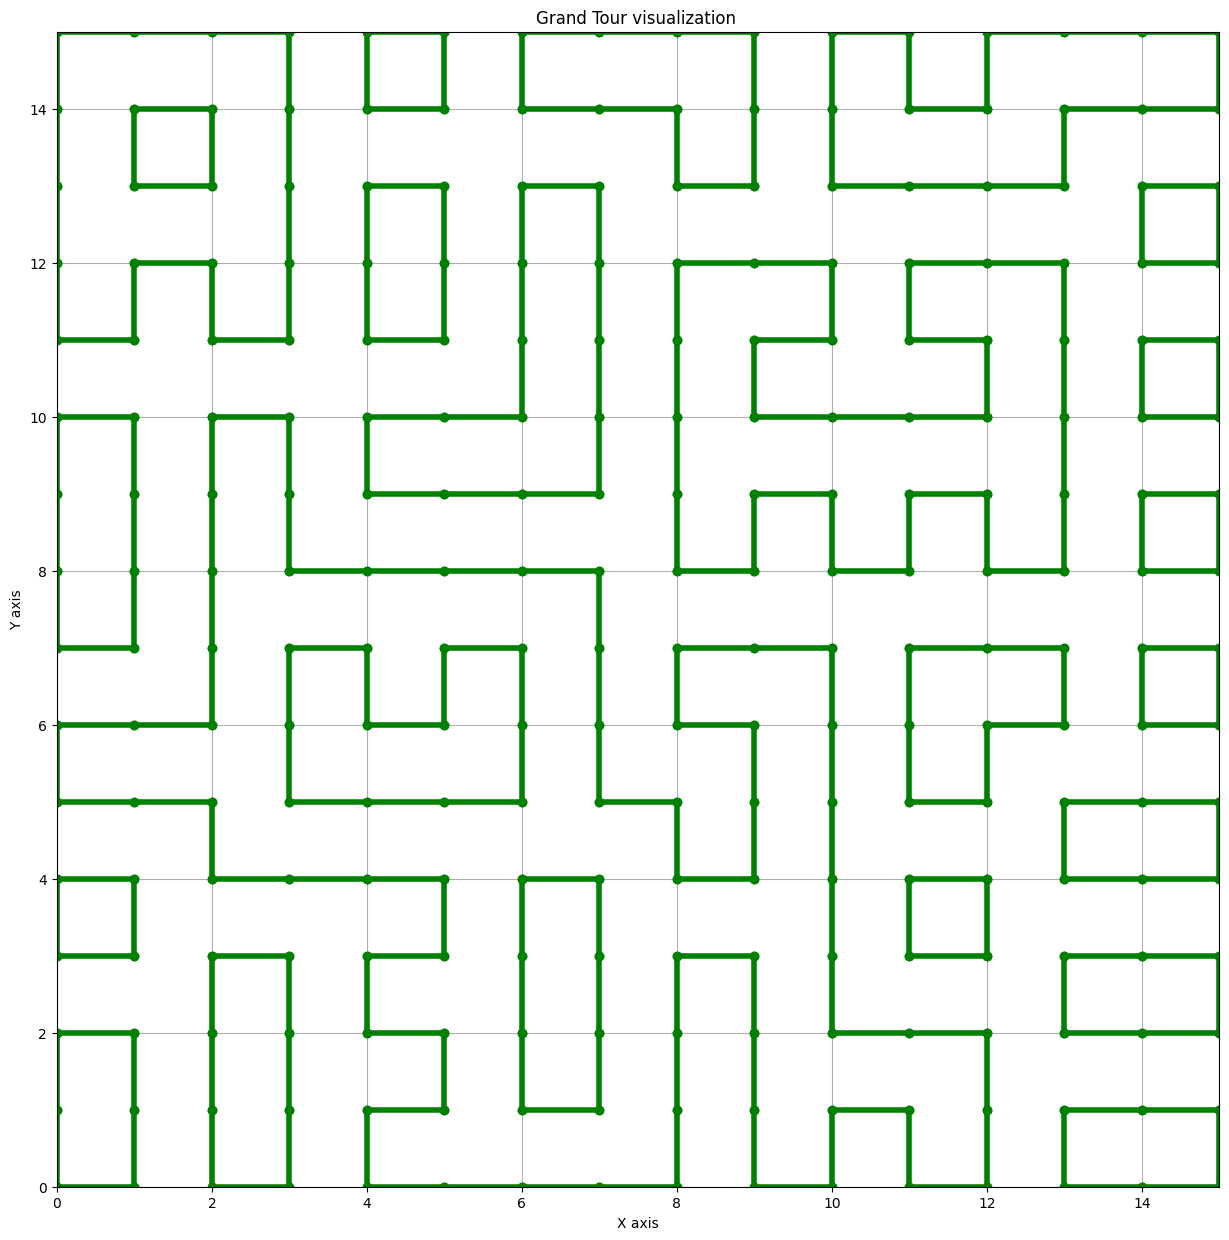

In [20]:
plt.figure(figsize=(15, 15))
# 绘制点

# 绘制无人机飞行线路

for route in result['arcs']:
    
    begin, end = route[0], route[1]
    route_x, route_y = [], []
    route_x.append(begin % (n + 1))
    route_y.append(m - begin // (n + 1))
    
    route_x.append(end % (n + 1))
    route_y.append(m - end // (n + 1))
    # print(begin, end)

    plt.plot(route_x, route_y, 'go-', label='line 1', linewidth=4)

# 设置X轴和Y轴的范围
plt.xlim(0, 15)
plt.ylim(0, 15)
# 添加标题和轴标签
plt.title(f'Grand Tour visualization ')
plt.xlabel('X axis')
plt.ylabel('Y axis')
# 显示网格（可选）
plt.grid(True)
# 显示图形
plt.show()